# Importation des données

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

customers = pd.read_csv('data/customers.csv')
products = pd.read_csv('data/products.csv')
transactions = pd.read_csv('data/transactions.csv')

# Obtenir les infos en fonction de conditions

In [41]:
products.loc[(products["id_prod"] == "0_1507"), ["id_prod", "price", "categ"]]

,id_prod,price,categ
4,0_1507,3.99,0


# Vérification si il y a des transactions nulles

In [ ]:
missing_values = transactions.isnull().sum()
missing_values

# Vérification des doublons

In [ ]:
duplicate_transac = transactions[transactions.duplicated()]
duplicate_transac

In [ ]:
duplicate_prod = products[products.duplicated()]
duplicate_prod

In [ ]:
duplicate_custom = customers[customers.duplicated()]
duplicate_custom

# Ratio Hommes / Femmes

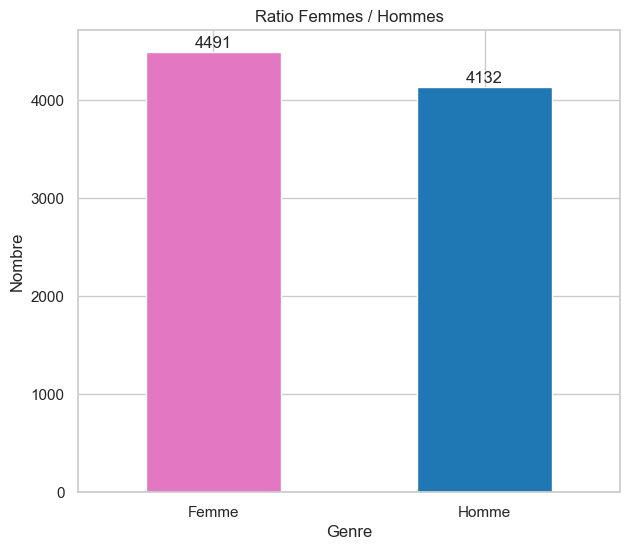

In [14]:
gender_counts = customers['sex'].value_counts()
plt.figure(figsize=(7, 6))
ax = gender_counts.plot(kind='bar', rot=0, color=["tab:pink", "tab:blue"])
ax.set_title("Ratio Femmes / Hommes", y=1)
ax.set_xlabel('Genre')
ax.set_ylabel('Nombre')
ax.set_xticklabels(('Femme', 'Homme'))
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

# Nombre de clients par année de naissance en fonction du genre

<Figure size 1500x600 with 0 Axes>

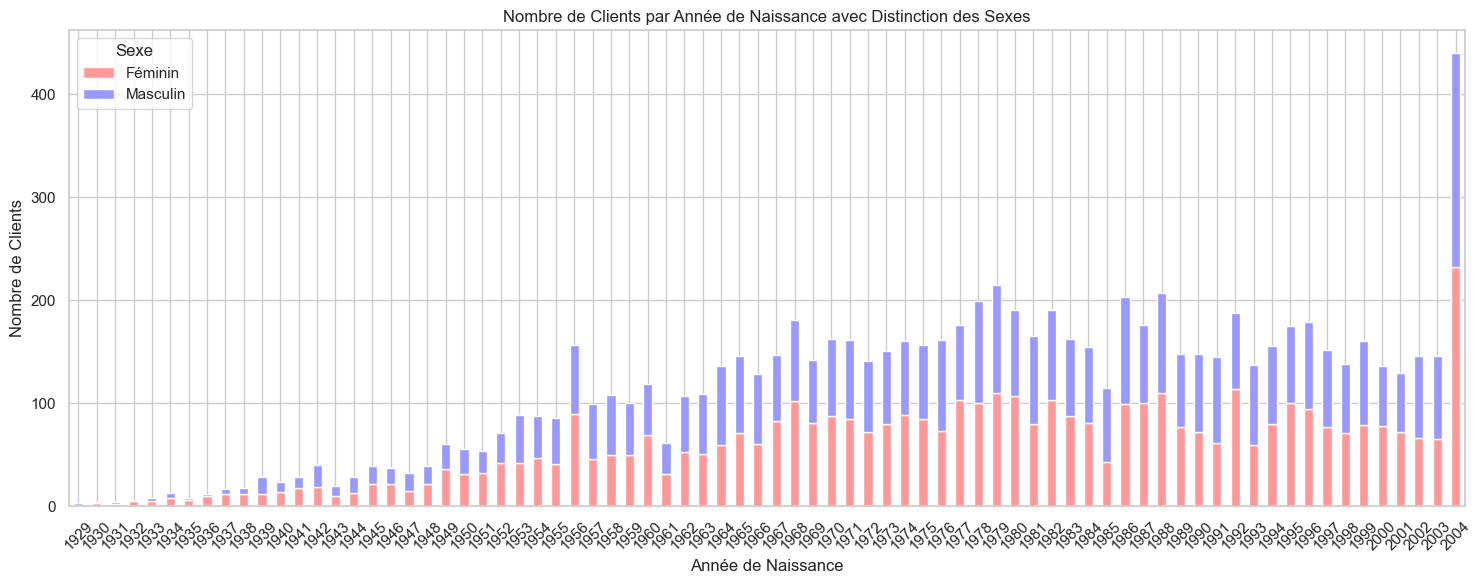

In [15]:
customers_by_sex_birth = customers.groupby(['sex', 'birth']).size().reset_index(name='count')
pivot_customers = customers_by_sex_birth.pivot(index='birth', columns='sex', values='count').fillna(0)
pivot_customers['Total'] = pivot_customers.sum(axis=1)
pivot_customers_sorted = pivot_customers.sort_values(by='Total')
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
pivot_customers[['f', 'm']].plot(kind='bar', stacked=True, color=['#ff9999', '#9999ff'], figsize=(15, 6))
plt.title('Nombre de Clients par Année de Naissance avec Distinction des Sexes')
plt.xlabel('Année de Naissance')
plt.ylabel('Nombre de Clients')
plt.xticks(rotation=45)
plt.legend(title='Sexe', labels=['Féminin', 'Masculin'])
plt.tight_layout()
plt.show()

# Tableau croisé entre sex et categorie

In [ ]:
tableau_croise = pd.crosstab(customers['sex'], products['categ'])
tableau_croise

# Les prix par catégorie

In [16]:
price_by_category = products.groupby('categ')['price'].describe()

price_by_category

,count,mean,std,min,25%,50%,75%,max
categ,,,,,,,,
0,2309.0,11.727280,7.568756,-1.00,5.580,10.32,16.65,40.99
1,739.0,25.531421,15.425162,2.00,13.390,22.99,33.99,80.99
2,239.0,108.354686,49.561431,30.99,71.065,101.99,136.53,300.00


# Retrait du produit négatif

In [17]:
products = products[products['price'] != -1]

produits_negatif_restant = products[products['price'] < 0].shape[0]

produits_negatif_restant

0

# Visualisation des prix par catégorie

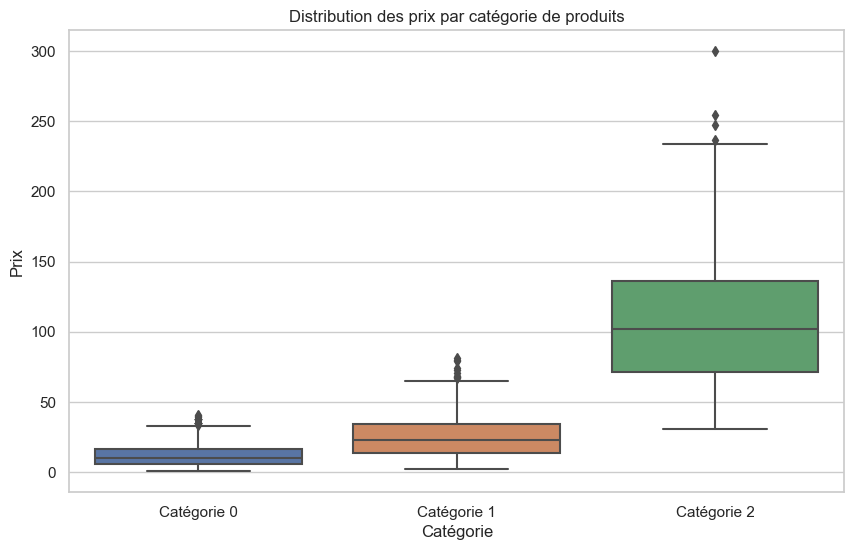

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='categ', y='price', data=products)

plt.title('Distribution des prix par catégorie de produits')
plt.xlabel('Catégorie')
plt.ylabel('Prix')
plt.xticks([0, 1, 2], ['Catégorie 0', 'Catégorie 1', 'Catégorie 2'])

plt.show()

# Nettoyage des transactions avec les dates test

In [19]:
transactions_cleaned = transactions[~transactions['date'].str.startswith("test")]
transactions_with_test = transactions[transactions['date'].str.startswith("test")]

original_count = transactions.shape[0]
cleaned_count = transactions_cleaned.shape[0]
test_transactions_removed = original_count - cleaned_count

(original_count, cleaned_count, test_transactions_removed, transactions_cleaned, transactions_with_test)

(337016,
 336816,
 200,
        id_prod                        date session_id client_id
 0       0_1483  2021-04-10 18:37:28.723910    s_18746    c_4450
 1        2_226  2022-02-03 01:55:53.276402   s_159142     c_277
 2        1_374  2021-09-23 15:13:46.938559    s_94290    c_4270
 3       0_2186  2021-10-17 03:27:18.783634   s_105936    c_4597
 4       0_1351  2021-07-17 20:34:25.800563    s_63642    c_1242
 ...        ...                         ...        ...       ...
 337011   1_671  2021-05-28 12:35:46.214839    s_40720    c_3454
 337012   0_759  2021-06-19 00:19:23.917703    s_50568    c_6268
 337013  0_1256  2021-03-16 17:31:59.442007     s_7219    c_4137
 337014   2_227  2021-10-30 16:50:15.997750   s_112349       c_5
 337015  0_1417  2021-06-26 14:38:19.732946    s_54117    c_6714
 
 [336816 rows x 4 columns],
        id_prod                             date session_id client_id
 1431       T_0  test_2021-03-01 02:30:02.237420        s_0      ct_1
 2365       T_0  test_2021

# Produits les plus vendus

In [20]:
transactions_by_product = transactions_cleaned.groupby('id_prod').size().sort_values(ascending=False)

transactions_by_product.head()

id_prod
1_369    1081
1_417    1062
1_498    1036
1_414    1027
1_425    1013
dtype: int64

# Prix des articles

In [ ]:
freq_achat = products.groupby('price').agg({'id_prod': ', '.join})
freq_achat

# CA par produit

In [21]:
transactions_with_price = transactions_cleaned.merge(products[['id_prod', 'price']], on='id_prod', how='left')

total_revenue_by_product = transactions_with_price.groupby('id_prod').agg(
    transactions_count=('id_prod', 'size'),
    total_revenue=('price', 'sum')
).sort_values(by='total_revenue', ascending=False)

total_revenue_by_product.head()

,transactions_count,total_revenue
id_prod,,
2_135,491,33874.09
2_112,473,31960.61
2_102,489,28919.46
2_209,390,27296.10
2_110,434,27016.50


# Graphique du top 10 des produits avec le plus gros CA

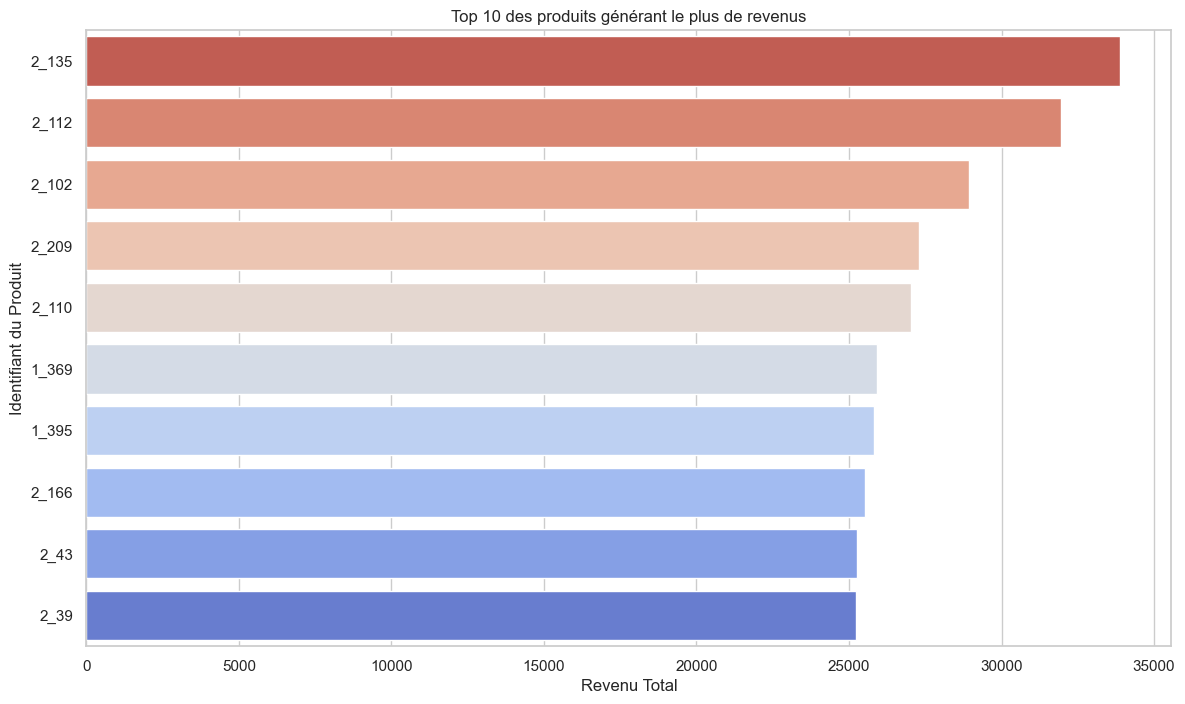

In [22]:
top_10_CA_products = total_revenue_by_product.head(10).reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(x='total_revenue', y='id_prod', data=top_10_CA_products, palette='coolwarm_r') #_r permet d'inverser les couleurs

plt.title('Top 10 des produits générant le plus de revenus')
plt.xlabel('Revenu Total')
plt.ylabel('Identifiant du Produit')
plt.show()

# Produits jamais vendus

In [45]:
sold_products = transactions_cleaned['id_prod'].unique()
unsold_products = products[~products['id_prod'].isin(sold_products)]

unsold_products

unsold_products_df = products[~products['id_prod'].isin(sold_products)]
chemin_fichier_csv_unsold = 'data/unsold_products.csv'
unsold_products_df.to_csv(chemin_fichier_csv_unsold, index=False)

In [37]:
jointure_outer = pd.merge(transactions, products, on='id_prod', how='outer')
non_vendus = jointure_outer[jointure_outer['session_id'].isna()]
non_vendus_final =non_vendus["id_prod"].count()
print("Nombre de produits non vendus :", non_vendus_final)

Nombre de produits non vendus : 22


# Nombre de transactions par date

/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_33972/2024325472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['just_date'] = data_filtered['date_converted'].dt.date


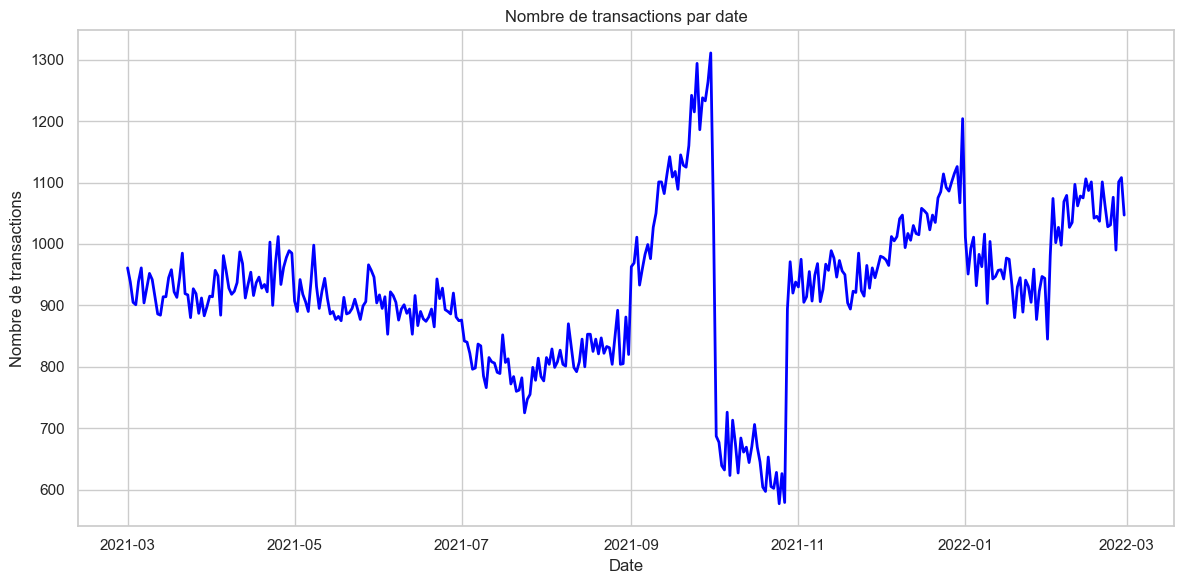

In [24]:
transactions['date_converted'] = pd.to_datetime(transactions['date'], errors='coerce')

data_filtered = transactions.dropna(subset=['date_converted'])

data_filtered['just_date'] = data_filtered['date_converted'].dt.date

transactions_by_date_filtered = data_filtered.groupby('just_date').size()

plt.figure(figsize=(12, 6))
transactions_by_date_filtered.plot(kind='line', color='blue', linewidth=2)
plt.title('Nombre de transactions par date')
plt.xlabel('Date')
plt.ylabel('Nombre de transactions')
plt.tight_layout()
plt.show()

# Détail du nombre de transactions sur la période suspecte

In [25]:
transactions_cleaned['date'] = pd.to_datetime(transactions_cleaned['date'], errors='coerce')

transactions_month = transactions_cleaned[transactions_cleaned['date'].dt.month.isin([8, 9, 10, 11, 12])]

transactions_month_with_categ = transactions_month.merge(products[['id_prod', 'price', 'categ']], on='id_prod', how='left')

transactions_details_by_categ = transactions_month_with_categ.groupby([transactions_month_with_categ['date'].dt.month, 'categ']).agg(
    number_of_transactions=('id_prod', 'count'),
    total_revenue=('price', 'sum')
).rename(index={8: 'Aout', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}, level=0)

transactions_details_by_categ

/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_33972/4010835067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_cleaned['date'] = pd.to_datetime(transactions_cleaned['date'], errors='coerce')


number_of_transactions  total_revenue
date      categ                                       
Aout      0.0                     15708      167677.82
          1.0                      7954      162991.38
          2.0                      1948      148635.99
September 0.0                     23112      246264.21
          1.0                      9268      190613.78
          2.0                       874       65893.29
October   0.0                     18751      199217.94
          1.0                      1666       33762.32
          2.0                      1160       86179.70
November  0.0                     14578      155843.78
          1.0                     12316      252910.39
          2.0                      1373      104136.00
December  0.0                     19282      205976.44
          1.0                     12259      251026.75
          2.0                       876       65934.49

# Nombre de transactions par jour en Octobre

In [26]:
transactions_with_categ = transactions_cleaned.merge(products[['id_prod', 'price', 'categ']], on='id_prod', how='left')

transactions_oct_categ1 = transactions_with_categ[
    (transactions_with_categ['date'].dt.month == 10) &
    (transactions_with_categ['categ'] == 1)
]

transactions_details_by_day_categ1 = transactions_oct_categ1.groupby([
    transactions_oct_categ1['date'].dt.month,
    transactions_oct_categ1['date'].dt.day
]).agg(
    number_of_transactions=('id_prod', 'count'),
    total_revenue=('price', 'sum')
).rename(index={10: 'October'}, level=1)

transactions_details_by_day_categ1

number_of_transactions  total_revenue
date date                                       
10   1                        344        7003.79
     28                       316        6317.99
     29                       326        6425.18
     30                       338        6753.69
     31                       342        7261.67

# Top 10 des clients

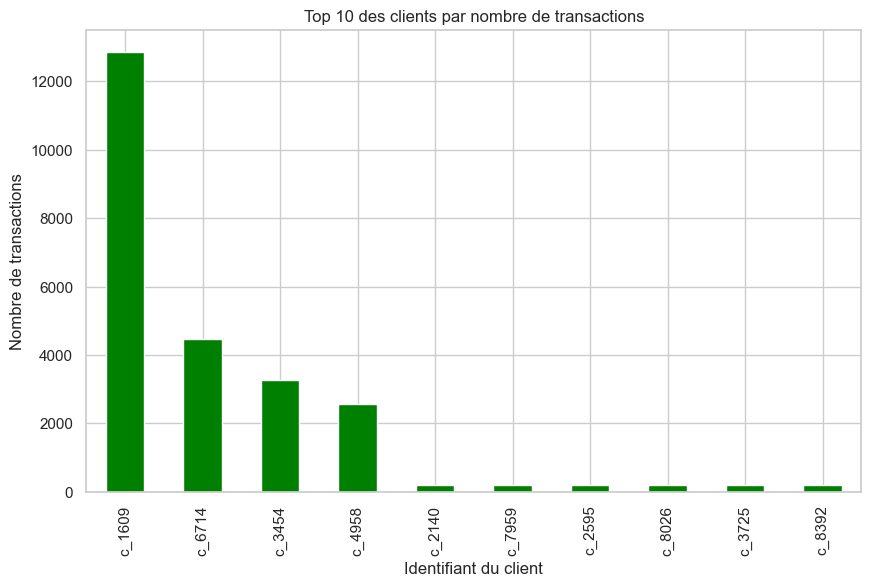

client_id
c_1609    12855
c_6714     4473
c_3454     3275
c_4958     2562
c_2140      195
c_7959      195
c_2595      193
c_8026      193
c_3725      190
c_8392      189
Name: count, dtype: int64

In [27]:
transactions_by_client = data_filtered['client_id'].value_counts().head(10)

plt.figure(figsize=(10, 6))
transactions_by_client.plot(kind='bar', color='green')
plt.title('Top 10 des clients par nombre de transactions')
plt.xlabel('Identifiant du client')
plt.ylabel('Nombre de transactions')
plt.show()

transactions_by_client

# Top 10 des clients ayant le plus dépensé

In [28]:
transactions_et_prix_df = pd.merge(transactions, products, on='id_prod', how='left')

montant_total_par_client = transactions_et_prix_df.groupby('client_id')['price'].sum().reset_index()

montant_total_par_client = montant_total_par_client.sort_values(by='price', ascending=False)

top_10_clients_par_depenses = montant_total_par_client.head(10)
top_10_clients_par_depenses


,client_id,price
677,c_1609,162007.34
4388,c_4958,144257.21
6337,c_6714,73197.34
2724,c_3454,54442.92
7715,c_7959,2564.25
3870,c_4491,2540.53
7791,c_8026,2537.67
1268,c_2140,2527.01
8195,c_8392,2515.98
7120,c_7421,2511.98


# Nettoyage des 4 gros clients

In [29]:
clients_a_exclure = ['c_1609', 'c_4958', 'c_6714', 'c_3454']
donnees_sans_gros_clients = transactions_et_prix_df[~transactions_et_prix_df['client_id'].isin(clients_a_exclure)]

transactions_par_client_sans_gros = donnees_sans_gros_clients['client_id'].value_counts().reset_index()
transactions_par_client_sans_gros.columns = ['client_id', 'nombre_transactions']

montant_total_par_client_sans_gros = donnees_sans_gros_clients.groupby('client_id')['price'].sum().reset_index().sort_values(by='price', ascending=False)

top_10_clients_par_transactions_sans_gros = transactions_par_client_sans_gros.head(10)
top_10_clients_par_depenses_sans_gros = montant_total_par_client_sans_gros.head(10)

top_10_clients_par_transactions_sans_gros, top_10_clients_par_depenses_sans_gros

(  client_id  nombre_transactions
 0    c_7959                  195
 1    c_2140                  195
 2    c_8026                  193
 3    c_2595                  193
 4    c_3725                  190
 5    c_8392                  189
 6    c_7421                  189
 7    c_2077                  188
 8    c_3263                  188
 9    c_5922                  187,
      client_id    price
 7711    c_7959  2564.25
 3868    c_4491  2540.53
 7787    c_8026  2537.67
 1267    c_2140  2527.01
 8191    c_8392  2515.98
 7116    c_7421  2511.98
 2512    c_3263  2493.32
 3022    c_3725  2450.38
 8465     c_880  2432.39
 1771    c_2595  2423.27)

# Top 10 des clients suite au nettoyage

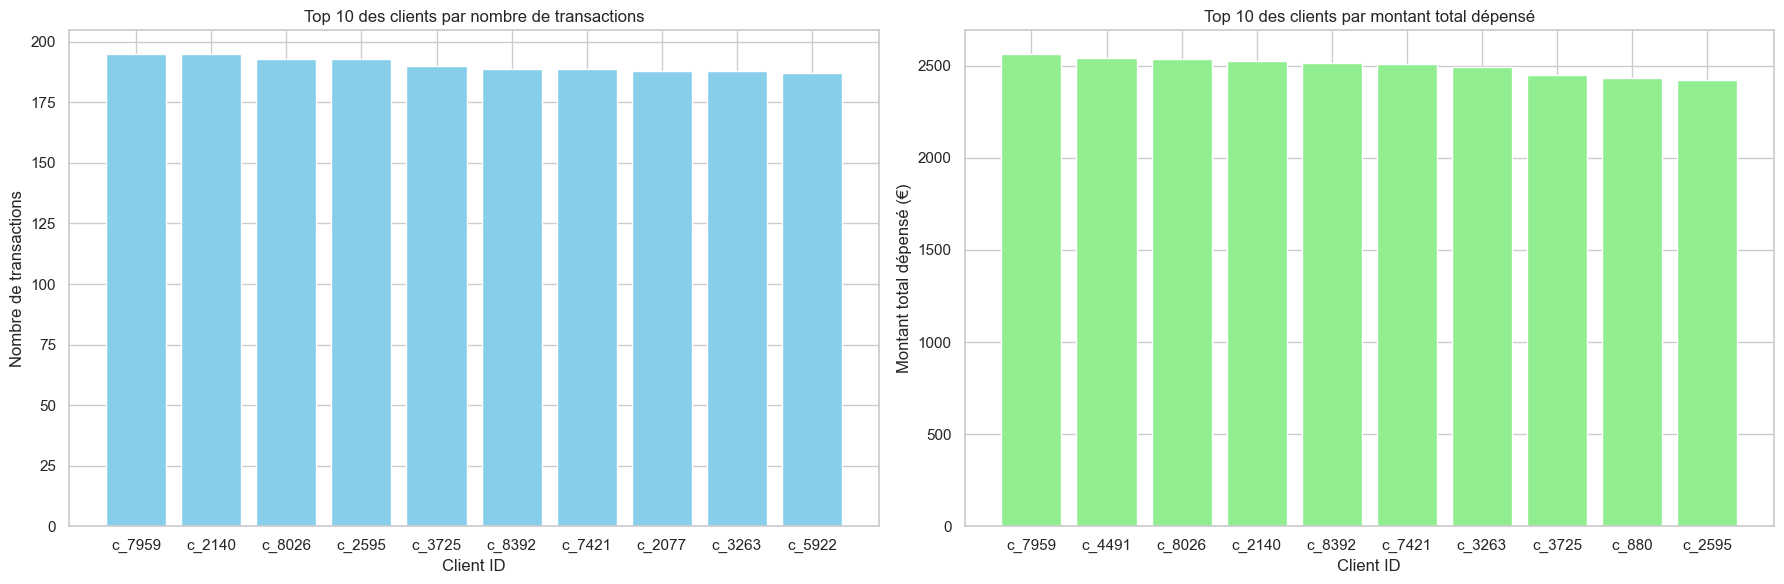

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].bar(top_10_clients_par_transactions_sans_gros['client_id'], top_10_clients_par_transactions_sans_gros['nombre_transactions'], color='skyblue')
axes[0].set_title('Top 10 des clients par nombre de transactions')
axes[0].set_xlabel('Client ID')
axes[0].set_ylabel('Nombre de transactions')
axes[0].tick_params(axis='x')

axes[1].bar(top_10_clients_par_depenses_sans_gros['client_id'], top_10_clients_par_depenses_sans_gros['price'], color='lightgreen')
axes[1].set_title('Top 10 des clients par montant total dépensé')
axes[1].set_xlabel('Client ID')
axes[1].set_ylabel('Montant total dépensé (€)')
axes[1].tick_params(axis='x')

plt.tight_layout()
plt.show()

# Clients sans transactions

In [43]:
nombre_de_clients_sans_achat = 0
clients_sans_achat = set(customers['client_id']) - set(transactions['client_id'])
for client in clients_sans_achat:
    nombre_de_clients_sans_achat += 1
print("Nombre de clients n'ayant pas effectué d'achat :", nombre_de_clients_sans_achat)

clients_sans_achat_df = pd.DataFrame(list(clients_sans_achat), columns=['client_id'])
chemin_csv = 'data/clients_sans_achat.csv'
clients_sans_achat_df.to_csv(chemin_csv, index=False)

Nombre de clients n'ayant pas effectué d'achat : 21


# En prenant la variable nettoyée

In [38]:
nombre_de_clients_sans_test = 0
clients_sans_test = set(transactions['date'].str.startswith('test'))
for client in clients_sans_test:
    nombre_de_clients_sans_test += 1
print("Nombre de clients n'ayant pas effectué d'achat :", nombre_de_clients_sans_test)

Nombre de clients n'ayant pas effectué d'achat : 2


In [39]:
nombre_de_clients_sans_achat_clean = 0
clients_sans_achat_clean = set(customers['client_id']) - set(transactions_cleaned['client_id'])

print("Noms des clients n'ayant pas effectué d'achat :")
for client_id in clients_sans_achat_clean:
    nombre_de_clients_sans_achat_clean += 1
    client_name = customers.loc[customers['client_id'] == client_id, 'client_id'].iloc[0]
    print(f"- {client_name}")

print("Nombre de clients n'ayant pas effectué d'achat :", nombre_de_clients_sans_achat_clean)

Noms des clients n'ayant pas effectué d'achat :
- c_5223
- c_8253
- c_4358
- c_5245
- c_587
- c_90
- c_4086
- c_4406
- c_8381
- c_2706
- c_6862
- c_3526
- c_7584
- c_6930
- c_3789
- ct_0
- c_1223
- c_3443
- ct_1
- c_3017
- c_6735
- c_4447
- c_862
Nombre de clients n'ayant pas effectué d'achat : 23


# Médiane des livres de toutes les catégories

In [40]:
median_prix_tous_livres = products['price'].median()
print("Médiane des prix de tous les livres:", median_prix_tous_livres)

Médiane des prix de tous les livres: 13.075


# Changement du produit sans prix

In [ ]:
nouveau_produit = pd.DataFrame([{'id_prod': '0_2245', 'price': median_prix_tous_livres, 'categ': pd.NA}])
products_df_modifie = pd.concat([products, nouveau_produit], ignore_index=True)
produit_0_2245_ajoute = products_df_modifie[products_df_modifie['id_prod'] == '0_2245']
produit_0_2245_ajoute
products_df_modifie.loc[products_df_modifie['id_prod'] == '0_2245', 'categ'] = 0
produit_0_2245_mis_a_jour = products_df_modifie[products_df_modifie['id_prod'] == '0_2245']
produit_0_2245_mis_a_jour

# CA par catégorie

In [31]:
ca_par_categorie = transactions_et_prix_df.groupby('categ')['price'].sum()

ca_par_categorie

categ
0.0    2229722.65
1.0    2247384.41
2.0    1319470.71
Name: price, dtype: float64

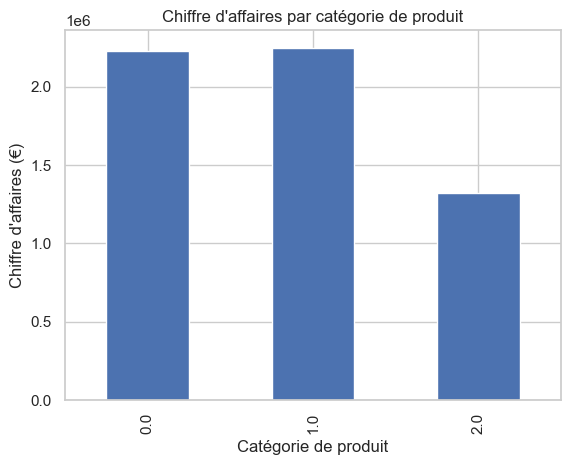

In [32]:
fig, ax = plt.subplots()
ca_par_categorie.plot(kind='bar', ax=ax)
ax.set_title('Chiffre d\'affaires par catégorie de produit')
ax.set_xlabel('Catégorie de produit')
ax.set_ylabel('Chiffre d\'affaires (€)')
plt.show()

# Transactions par genre et catégorie

In [33]:
transactions_clients_df = pd.merge(transactions_et_prix_df, customers[['client_id', 'sex']], on='client_id', how='left')

achats_par_categorie_et_genre = transactions_clients_df.groupby(['categ', 'sex']).size().unstack(fill_value=0)

achats_par_categorie_et_genre

sex,f,m
categ,,
0.0,103786,105640
1.0,55469,54266
2.0,8260,9292


# 1 ligne par client

In [47]:
current_year = pd.Timestamp('now').year
customers['age'] = current_year - customers['birth']

merged_data = transactions_cleaned.merge(customers, on='client_id')
merged_data = merged_data.merge(products, on='id_prod')

clients_agg = merged_data.groupby(['client_id', 'sex', 'age']).agg(
    frequency=('session_id', pd.Series.nunique),
    total_revenue=('price', 'sum')
).reset_index()

clients_agg['average_basket'] = clients_agg['total_revenue'] / clients_agg['frequency']

categ_revenue = merged_data.pivot_table(
    index='client_id',
    columns='categ',
    values='price',
    aggfunc='sum',
    fill_value=0
)

final_table = clients_agg.join(categ_revenue, on='client_id')

final_table

chemin_fichier_csv_table = 'data/one_by_client.csv'
final_table.to_csv(chemin_fichier_csv_table, index=False)

chemin_fichier_csv_table

'data/one_by_client.csv'

# Corrélation

In [35]:
correlation_final = final_table[['age', 'frequency', 'total_revenue', 'average_basket', 0, 1, 2]].corr()
correlation_final

,age,frequency,total_revenue,average_basket,0,1,2
age,1.000000,0.034473,-0.039311,-0.635116,0.001871,0.071732,-0.118598
frequency,0.034473,1.000000,0.908031,-0.070662,0.903133,0.944583,0.282648
total_revenue,-0.039311,0.908031,1.000000,0.031288,0.763028,0.872090,0.625651
average_basket,-0.635116,-0.070662,0.031288,1.000000,-0.069433,-0.073368,0.166384
0,0.001871,0.903133,0.763028,-0.069433,1.000000,0.818031,0.002548
1,0.071732,0.944583,0.872090,-0.073368,0.818031,1.000000,0.259693
2,-0.118598,0.282648,0.625651,0.166384,0.002548,0.259693,1.000000


# HeatMap

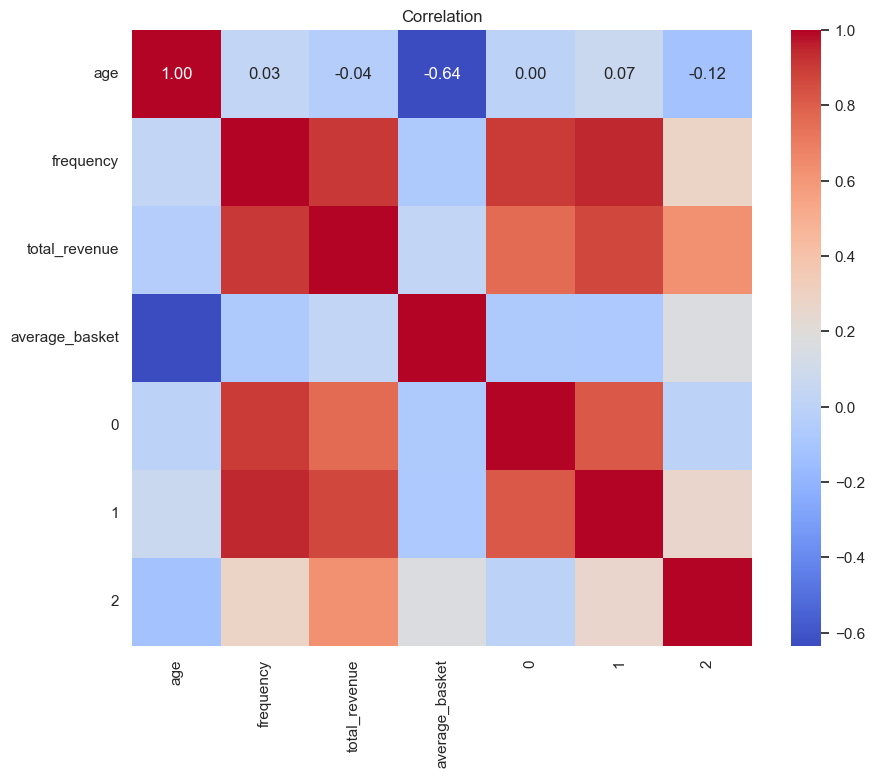

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_final, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation')
plt.show()